In [47]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from abc import ABC, abstractmethod

In [48]:
def MSE(y: NDArray, y_predict: NDArray):
    squared_errors = (y - y_predict)**2
    return np.mean(squared_errors)

def RMSE(y: NDArray, y_predict: NDArray):
    return np.sqrt(MSE(y, y_predict))

# Scalers

In [49]:
class Scaler(ABC):
    @abstractmethod
    def normalize(self, X: NDArray, update_params: bool = False) -> NDArray:
        pass

    @abstractmethod
    def denormalize(self, X: NDArray) -> NDArray:
        pass


class StandardScaler(Scaler):
    def __init__(self):
        self.mean: NDArray = None
        self.std: NDArray = None
        pass

    def normalize(self, X: NDArray, update_params: bool = False):
        mean = np.mean(X, axis=0) if self.mean is None or update_params else self.mean
        std = np.std(X, axis=0) if self.std is None or update_params else self.std

        self.mean = mean
        self.std = std

        return (X - mean) / std

    def denormalize(self, X: NDArray):
        return X * self.std + self.mean


class MinMaxScaler(Scaler):
    def __init__(self):
        self.min = None
        self.max = None
        pass

    def normalize(self, X: NDArray, update_params: bool = False):
        min = np.min(X, axis=0) if self.min is None or update_params else self.min
        max = np.max(X, axis=0) if self.max is None or update_params else self.max

        self.min = min
        self.max = max

        return (X - min) / (max - min)

    def denormalize(self, X: NDArray):
        return X * (self.max - self.min) + self.min


# Model training classes

In [50]:
class Model(ABC):
    @abstractmethod
    def train(self, X: NDArray, y: NDArray):
        pass

    @abstractmethod
    def predict(self, X: NDArray) -> NDArray:
        pass


class OLS(Model):
    def __init__(self):
        self.w: NDArray = None
        self.in_scaler = MinMaxScaler()
        self.out_scaler = StandardScaler()

    def train(self, X: NDArray, y: NDArray):
        X = self._preprocess_input(X, True)
        y = self._proprocess_output(y, True)

        w = np.linalg.solve(X.T @ X, X.T @ y)

        self.w = w

    def predict(self, X: NDArray):
        X = self._preprocess_input(X, False)
        y_predict = X @ self.w

        return self.out_scaler.denormalize(y_predict)

    def _preprocess_input(self, X: NDArray, update_params: bool = False):
        n, m = X.shape
        X_normalized = self.in_scaler.normalize(X, update_params)
        return np.c_[np.ones(n), X_normalized]

    def _proprocess_output(self, y: NDArray, update_params: bool = False):
        return self.out_scaler.normalize(y, update_params)


class GD(Model):
    def __init__(self):
        self.w: NDArray = None
        self.in_scaler = MinMaxScaler()
        self.out_scaler = StandardScaler()
        self.metrics: list[float] = []

    def train(self, X: NDArray, y: NDArray, epochs: int = 1000, learning_rate: float = 0.001):
        X = self._preprocess_input(X, True)
        y = self._proprocess_output(y, True)
        n, m = X.shape

        w = np.zeros((m, 1))

        self.metrics = []
        for _ in range(epochs):
            y_predict = X @ w

            errors = y - y_predict
            gradient = X.T @ errors
            w = w + learning_rate * gradient

            self.metrics.append(MSE(y, y_predict))

        self.w = w

    def predict(self, X: NDArray):
        X = self._preprocess_input(X, False)
        y_predict = X @ self.w

        return self.out_scaler.denormalize(y_predict)

    def _preprocess_input(self, X: NDArray, update_params: bool = False):
        n, m = X.shape
        X_normalized = self.in_scaler.normalize(X, update_params)
        return np.c_[np.ones(n), X_normalized]

    def _proprocess_output(self, y: NDArray, update_params: bool = False):
        return self.out_scaler.normalize(y, update_params)


class SGD(Model):
    def __init__(self):
        self.w: NDArray = None
        self.in_scaler = MinMaxScaler()
        self.out_scaler = StandardScaler()
        self.metrics: list[float] = []

    def train(self, X: NDArray, y: NDArray, epochs: int = 1000, learning_rate: float = 0.001):
        X = self._preprocess_input(X, True)
        y = self._proprocess_output(y, True)
        n, m = X.shape

        w = np.zeros((m, 1))

        self.metrics = []
        for _ in range(ceil(epochs / n)):
            data_order = np.random.permutation(n)
            for i in data_order:
                y_predict = X[i] @ w

                error = y[i] - y_predict
                gradient = (X[i].reshape((1, -1)).T * error)
                w = w + learning_rate * gradient

                self.metrics.append(MSE(y, X @ w))

        self.w = w

    def predict(self, X: NDArray):
        X = self._preprocess_input(X, False)
        y_predict = X @ self.w

        return self.out_scaler.denormalize(y_predict)

    def _preprocess_input(self, X: NDArray, update_params: bool = False):
        n, m = X.shape
        X_normalized = self.in_scaler.normalize(X, update_params)
        return np.c_[np.ones(n), X_normalized]

    def _proprocess_output(self, y: NDArray, update_params: bool = False):
        return self.out_scaler.normalize(y, update_params)



In [51]:
def genereate_dataset(filename: str) -> tuple[NDArray, NDArray]:
    dataset = np.genfromtxt(filename, delimiter=',')

    X = dataset[:, :-1]
    y = dataset[:, -1].astype(float).reshape((-1, 1))

    return X, y

def plot_metrics(metrics: NDArray, title: str):
    plt.plot(metrics)
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.title(title)
    plt.show()

def plot_result(X: NDArray, y: NDArray, model: Model, title: str):
    plt.scatter(X, y)
    plt.plot(X, model.predict(X))
    plt.title(title)
    plt.show()

In [52]:
X, y = genereate_dataset('artificial1d.csv')

## a) Treinamento utilizando OLS

(OLS) pesos: [-1.50352373] [3.00704747]
(OLS) MSE Final: 0.21340090132936992


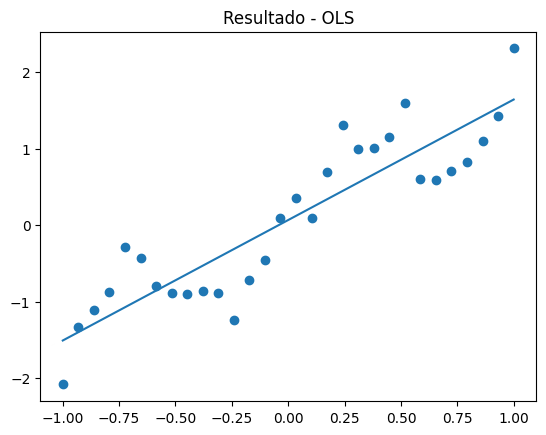

In [53]:
ols_model = OLS()
ols_model.train(X, y)
print('(OLS) pesos:', *ols_model.w)
print('(OLS) MSE Final:', MSE(y, ols_model.predict(X)))
plot_result(X, y, ols_model, 'Resultado - OLS')


## b) Treinamento utilizando Gradiente Descendente (GD)

(GD) pesos: [-1.50352373] [3.00704747]
(GD) MSE Final: 0.21340090132936987


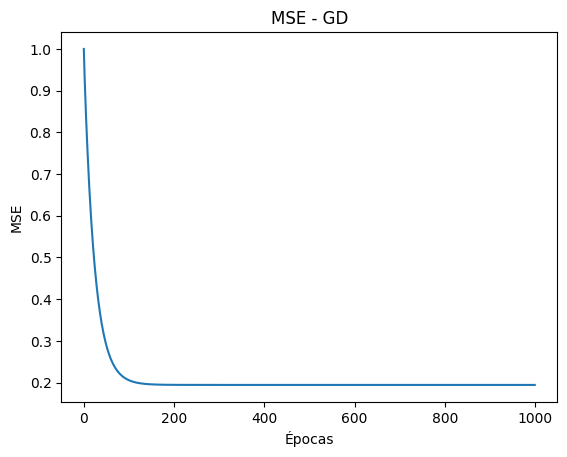

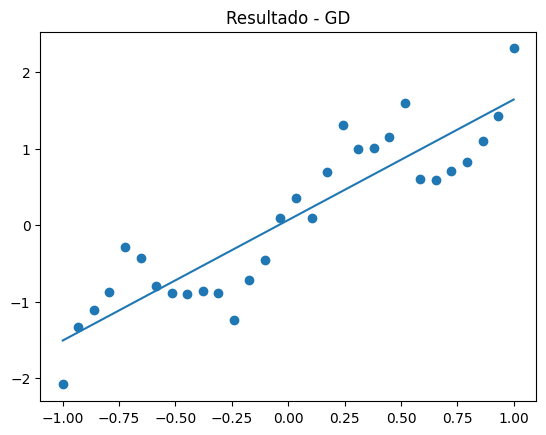

In [54]:
gd_model = GD()
gd_model.train(X, y, epochs=1000, learning_rate=0.01)
print('(GD) pesos:', *gd_model.w)
print('(GD) MSE Final:', MSE(y, gd_model.predict(X)))
plot_metrics(gd_model.metrics, 'MSE - GD')
plot_result(X, y, gd_model, 'Resultado - GD')


## c) Treinamento utilizando Gradiente Descendente Estocástico (SGD)

(SGD) pesos: [-1.49790063] [3.00589731]
(SGD) MSE Final: 0.21342898880159458


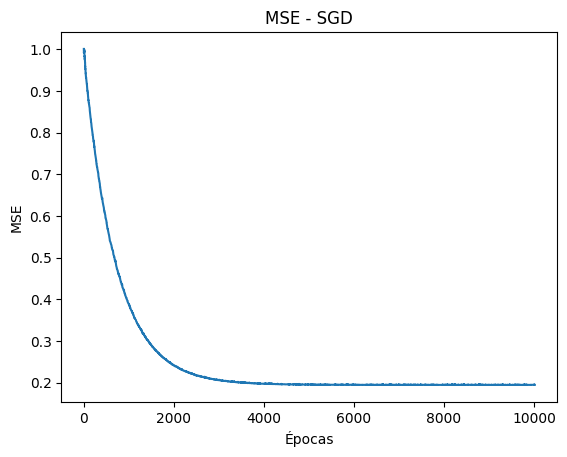

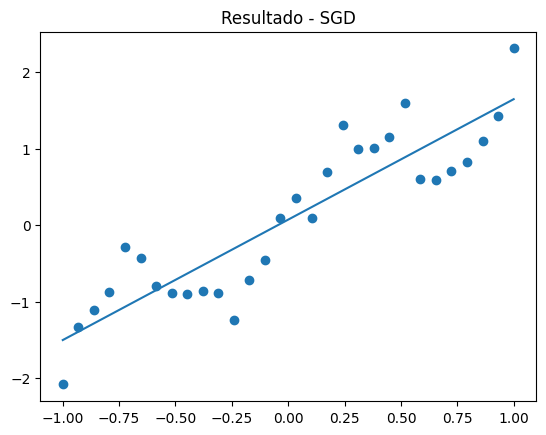

In [55]:
sgd_model = SGD()
sgd_model.train(X, y, epochs=10000, learning_rate=0.01)
print('(SGD) pesos:', *sgd_model.w)
print('(SGD) MSE Final:', MSE(y, sgd_model.predict(X)))
plot_metrics(sgd_model.metrics, 'MSE - SGD')
plot_result(X, y, sgd_model, 'Resultado - SGD')
